# K Nearest Neighbors & Cross-Validation

*Supervised machine learning* attempts to predict a *label* from a set of *features*.  There are two types of supervised problems; they are differentiated by the nature of the labels that are being predicted.  

1. Regression - the label can take numeric values in a continuous range.
2. Classification - the label can take a finite set of values.

In the previous chapters, we discussed several variants of *linear regression*, which are simple approaches to regression.  In this tutorial, we are going to introduce *K-nearest-neighbors* (KNN) which is a simple machine learning algorithm that can be used for both regression and classification. 

Our focus is going be on KNN as a classifier.  In particular, we will set up a simple financial classification problem and use it as a way to explore various concepts in machine learning, including the *variance-bias trade off* and *cross-validation*.

### Loading Packages

Let's begin by loading the packages that we will need.

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn
import matplotlib.pyplot as plt

## Various VIX Indices

Let's begin with a brief discussion of the data we will be analyzing.

The VIX volatility index is published by the CBOE and is a measure of 30-day implied volatility for the S&P 500 index.  Using that same methodology, the CBOE publishes other volatility measures on other stock indices and ETFs, such as the Russell 2000 and EWZ.  Most of the CBOE volatility measures have a 30-day tenor, meaning they are calculated using options that have approximately 30 days to maturity.

There are, however, several CBOE volatility indices with different tenors.  For the S&P 500, in addition to the standard 30-day VIX, there are indices with the following tenors: 9-day, 3-month, 6-month, and 1-year.  The analysis in this tutorial is going to involve four of these different S&P 500 VIX tenors.

## Reading-In the Data

Let's read-in our data set into a variable called `df_vix`.

In [ ]:
df_vix = pd.read_csv('vix_knn.csv')
df_vix = df_vix[df_vix.trade_date > '2011-01-03'] #removing the first row of NaNs
df_vix.head()

trade_date  vix_009  vix_030  vix_090  vix_180   spy_ret
1  2011-01-04     0.02    -0.23    -0.01    -0.21 -0.000551
2  2011-01-05    -0.49    -0.36    -0.56    -0.41  0.005198
3  2011-01-06     0.14     0.38     0.30     0.09 -0.001959
4  2011-01-07    -0.70    -0.26    -0.06     0.05 -0.001962
5  2011-01-10     0.80     0.40     0.19     0.01 -0.001259

This data set consists of daily SPY returns, and also daily changes in the 9-day, 30-day, 3-month, 6-month VIX indices.  I excluded the 1-year index because there is limited historical data.  The data is from 2011-2018.

## A Visualization Aside: Pair-Plots with Seaborn

Before jumping into classification with KNN, let's try the `pairplot()` function in the **seaborn** package. This function is useful for simultaneously visualizing pairwise relationships for several variables.

Let's apply this function to the various VIX indices in our data set.

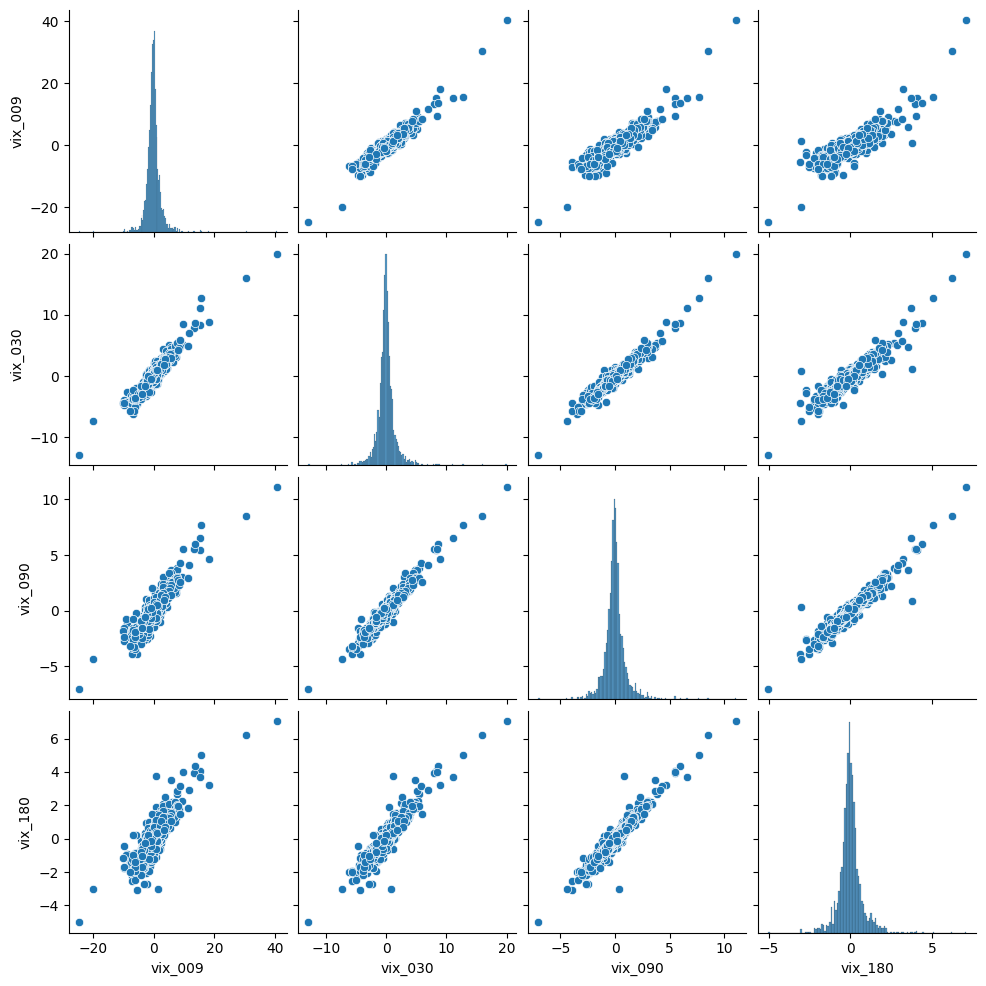

In [ ]:
sns.pairplot(df_vix[['vix_009', 'vix_030', 'vix_090', 'vix_180']]);

--- 

**Challenge Question:** How would you characterize the pairwise relationship between the various VIX tenors?

In [ ]:
#| code-fold: true
#| code-summary: "Solution"
# All the vix indices are highly correlated with one another.


---

## Our Simple Classification Problem

The *leverage effect* is a stylized fact about equity index volatility markets; it encapsulates the observation there is an inverse relationship between returns and implied volatility.  When returns are negative, implied vols increase; when returns are positive, implied vols decrease.  In a previous chapter we quantified this relationship with a `LinearRegression`, and found the relationship to be quite strong.


Based on our knowledge of this relationship let's consider a simple classification exercise: identify whether a return was a "gain" or "loss", based on changes in the various VIX indices.  

In the language of machine learning:

1. Label: today's return as a "gain" or "loss"
2. Features: changes in the VIX indices

## Some Simple Classifiers

For illustrative purposes, and also for the purposes of benchmarking performance, let's consider some simple classification schemes.

### **Random Guessing**

A completely random prediction is right 50% of the time.  This represents the lower-bound of performance of any learning model.

The code below uses `DataFrame` masking to check the performance of random guessing.

In [ ]:
# setting random seed
np.random.seed(100)

# making random label predictions
df_vix['rand_label'] = np.random.randint(0, 2, df_vix.shape[0])

# masking conditions that identify successful predictions
cond1 = (df_vix.rand_label == 0) & (df_vix.spy_ret <= 0)
cond2 = (df_vix.rand_label == 1) & (df_vix.spy_ret >= 0)

# using masking to calculate the success rate
(df_vix[cond1 | cond2].shape[0]) / (df_vix.shape[0])

0.5017404276479364

### **High Bias: Alway Guess 'Gain'**

What if we always predict a gain?  This is a great example of a classifier with a high bias and low variance.  It's smarter than random guessing because it is rooted in the knowledge that over long stretches of time, equity markets tend to rise (and also that markets rarely ever jump upwards).

In [ ]:
# always predict gain
(df_vix[df_vix.spy_ret > 0].shape[0]) / (df_vix.shape[0])

0.548483341621084

Since about 55% of the days in `df_vix` were gains for SPY, this predictor would have been right 55% of the time.

### **Leverage Effect Rule**

We could also create a simple rule-based classification that codifies our knowledge of the implied leverage effect.  The rule could simply be that if there is an increase in the VIX, predict a SPY loss; if there is a decrease in the VIX predict an SPY gain.  We will use 30-day VIX for this classifier.

This simple rule produces accurate labels 80% of the time, which further illustrates the strength of the implied leverate effect. 

In [ ]:
# conditions that define successful predictions
cond1 = (df_vix.vix_030 >= 0) & (df_vix.spy_ret <= 0)
cond2 = (df_vix.vix_030 <= 0) & (df_vix.spy_ret >= 0)

# calculating the proportions of successful conditions
(df_vix[cond1 | cond2].shape[0]) / (df_vix.shape[0])

0.8050721034311288

A more sophisticated classifier involving VIX changes should perform at least as well as this, or else it is not adding much beyond simply capturing the leverage effect.

## K Nearest Neighbors (KNN)

KNN is a simple classification algorithm that is based on the following intuitive principle: feature observations that are similar, should have similar associated labels.  Feature similarity is determined by distance in Euclidean space.  


Here is how the KNN works.  Suppose you are trying to predict a label for a given feature observation:

1. Find the $K$ feature samples in the the training set that are closest to your feature observation.

1. Find the labels associated with those  $K$ closest samples.

2. The KNN prediction is the label that occurs most often in that set of $K$ labels.

KNN is an example of an *instance-based* classifier, there really is no "fitting" process other than storing the training data.  The prediction algorithm amounts to calculating distances between the feature observation and the other feature observations in the train set, sorting the feature set by this distance, and then surveying the labels of the $K$ closest feature observations.

### **Preparing the Data**

In anticipation of performing KNN on our data, let's add a label column and do some additional data cleaning.

The following code defines a simple function that will add a column of labels to our data set: `L` stands for a loss, `G` stands for a gain.

In [ ]:
def labeler(ret):
    if ret < 0:
        return('L')
    else:
        return('G')

Next, let's add a label column called `spy_label_0`.  We can do this conveniently with the `.apply()` method which has the effect of vectorizing our `labeler` function.

In [ ]:
df_vix.drop(['rand_label'], axis=1, inplace=True)
df_vix['spy_label_0'] = df_vix['spy_ret'].apply(labeler)
df_vix.head()

trade_date  vix_009  vix_030  vix_090  vix_180   spy_ret spy_label_0
1  2011-01-04     0.02    -0.23    -0.01    -0.21 -0.000551           L
2  2011-01-05    -0.49    -0.36    -0.56    -0.41  0.005198           G
3  2011-01-06     0.14     0.38     0.30     0.09 -0.001959           L
4  2011-01-07    -0.70    -0.26    -0.06     0.05 -0.001962           L
5  2011-01-10     0.80     0.40     0.19     0.01 -0.001259           L

### **Predicting with 30-day VIX**

In this section we'll apply KNN to various subsets of our VIX features, and train our model using the entirety of our data set.

Let's begin by importing the contructor function that we will need.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

We are now ready to fit our classifier model, let's begin by predicting the current day label with the standard (30-day) VIX.  We are going to use a $K$ value of 10.  As usual, our steps are:

1. Feature selection: identify the data we will be using to train with.

1. Model selection: instantiate the model using the constructor, and set model hyperparameters.

1. Fitting: using the `.fit()` of our instantiated mode.

In [ ]:
# (1) feature selection 
X = df_vix[['vix_030']]
y = df_vix['spy_label_0'].values

# (2) model selection and hyper-parameters
clf = KNeighborsClassifier(n_neighbors = 10)

# (3) fitting the model
clf.fit(X, y)

KNeighborsClassifier(n_neighbors=10)

The most fundamental metric for investigating the quality of a classifier is *accuracy*, which is simply the proportion of correct classifications.

Recall that for a `LinearRegression`, the `.score()` method gave the $R^2$ of the model.  For a `KNeighborsClassifier` the `.score()` method gives the accuracy.

In [ ]:
clf.score(X, y)

0.8219791148682247

Our accuracy is much better than random guessing, or a constant guess of `G`.  However, our KNN only slightly outperforms the leverage effect rule.

### **Predicting with Multiple VIX Indices**

Let's now add in the other VIX indices as additional features. Ultimately, we're interested in seeing if our in-sample accuracy improves.

When considering multiple features it is important to normalize the features to make sure they are all the same order of magnitude.  We can do this easily with the `scale()` function, who's default behavior is to subtract the mean, and divide by the standard deviation.

In [ ]:
# importing scale function
from sklearn.preprocessing import scale

## (1) feature selection
X = df_vix[['vix_009', 'vix_030', 'vix_090', 'vix_180']]
y = df_vix['spy_label_0'].values

# scaling fetures
Xs = scale(X)

## (2) model selection
clf = KNeighborsClassifier(n_neighbors = 10)

## (3) fitting the model
clf.fit(X, y)

# checking in-sample accuracy score
print(clf.score(X, y))

0.841869716558926


As we can see, there is a slight improvement in our in-sample accuracy.

---

**Discussion Question:** What would happen if we added option volume to our analysis but didn't normalize our feature set? 

In [ ]:
#| code-fold: true
#| code-summary: "Solution"
# Option volumes are numbers that are much larger than VIX values.  
# Therefore, if they are not normalized, they will dominate the fitting and 
# the VIX values will be ignored.

---

**Code Challenge:** Rerun the analysis with $K = 1$.  What do you make of the accuracy score?

In [ ]:
#| code-fold: true
#| code-summary: "Solution"

# importing scale function
from sklearn.preprocessing import scale

## (1) feature selection
X = df_vix[['vix_009', 'vix_030', 'vix_090', 'vix_180']]
y = df_vix['spy_label_0'].values

# scaling fetures
Xs = scale(X)

## (2) model selection
clf = KNeighborsClassifier(n_neighbors = 1)

## (3) fitting the model
clf.fit(X, y)

# checking in-sample accuracy score
print(clf.score(X, y))

1.0


## **Hold-Out Sets**

So far we have only been looking at our accuracy score in-sample, meaning we are simply calculating the accuracy score on the training set. This gives a skewed perception of how accurate the model will be on new data.

In order to account for this, we can partition the data set into two subsets, one for *training* the model and one for *testing* the trained model.  The `model_selection` module contains a convenience function for splitting data into training sets and testing sets.  It is called `train_test_split()`.  Let's import it now.

In [ ]:
from sklearn.model_selection import train_test_split

Let's again perform a KNN with multiple VIX indices, but this time splitting the data set.  We will then calculate the accuracy score of the model on both the training set and the test set.

In [ ]:
## (1) feature selection 
X = df_vix[['vix_009', 'vix_030', 'vix_090', 'vix_180']]
y = df_vix['spy_label_0'].values

# scaling fetures
Xs = scale(X)

# train-test_split the data
X_train, X_test, y_train, y_test = train_test_split(Xs, y, test_size=0.20, random_state=0)

## (2) model selection
clf = KNeighborsClassifier(n_neighbors = 10)

## (3) fitting the model
clf.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=10)

Now that we have fit our model, let's check for accuracy on both the training set and the test set.

In [ ]:
print('Train Accuracy: ', np.round(clf.score(X_train, y_train), 4))
print('Test Accuracy:  ', np.round(clf.score(X_test, y_test), 4))

Train Accuracy:  0.8451
Test Accuracy:   0.8337


Notice that the accuracy on the test set is lower than the accuracy on the training set.  This is almost always the case.

---

**Coding Challenge:**  Copy and paste the code from the example above, and then re-run it using a $K=1$.  Is the spread between training accuracy and testing accuracy larger or smaller than when $K=10$?

In [ ]:
#| code-fold: true
#| code-summary: "Solution"

## (1) feature selection 
X = df_vix[['vix_009', 'vix_030', 'vix_090', 'vix_180']]
y = df_vix['spy_label_0'].values

# scaling fetures
Xs = scale(X)

# train-test_split the data
X_train, X_test, y_train, y_test = train_test_split(Xs, y, test_size=0.20, random_state=0)

## (2) model selection
clf = KNeighborsClassifier(n_neighbors = 1)

## (3) fitting the model
clf.fit(X_train, y_train)

print('Train Accuracy: ', np.round(clf.score(X_train, y_train), 4))
print('Test Accuracy:  ', np.round(clf.score(X_test, y_test), 4))

Train Accuracy:  1.0
Test Accuracy:   0.804


---

## Cross-Validation

In the previous section we used `train_test_split()` to partition our data so that we could check the accuracy of our model on observations that were not used in the fitting process.  When doing this we noticed that the accuracy of our model is lower on the testing set then on the training set.  The testing set accuracy is more reflective of how the model would perform in the wild. 


But why stop with just doing this splitting once?  We could could do a `train_test_split()` multiple times, each time producing a different test accuracy.  This collection of accuracies, in aggregate, would form a more robust measure of model performance.  This is precisely the notion of model *cross-validation*.

The `cross_val_score()` function in the `model_selection` module provides a convenient way to perform cross-validation.

In [ ]:
# importing cross_val_score
from sklearn.model_selection import cross_val_score

# feature selection 
X = df_vix[['vix_009', 'vix_030', 'vix_090', 'vix_180']]
y = df_vix['spy_label_0'].values

# scaling fetures
Xs = scale(X)

# model selection
clf = KNeighborsClassifier(n_neighbors = 10)

# cross validation
cross_val_score(clf, Xs, y, cv=5)

array([0.82878412, 0.77363184, 0.83333333, 0.7960199 , 0.84825871])

The code above splits the data into five parts, and then performs a train-test-split on each of them.  Convenience functions like `cross_val_score()` are one of the reasons that **sklearn** is such a popular library.  This function works the same with all kinds of different models and saves us from writing a lot of boilerplate code.

## Visualizing the Variance-Bias Trade-Off

As discussed in a code challenge above, when $K=1$ the in-sample accuracy is perfect, but the out-of-sample accuracy is relatively poor.  This is a classic illustration of over-fitting the data.  By setting $K=1$ we are allowing for maximum model complexity.  Said in another way, we are attributing a lot of informational value to each (noisy) training observation.

The following code allows us to visualize this.

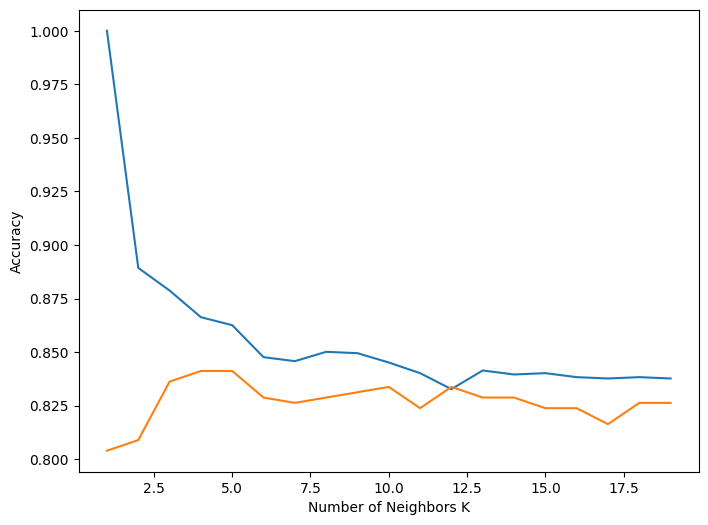

In [ ]:
# feature selection 
X = df_vix[['vix_009', 'vix_030', 'vix_090', 'vix_180']]
y = df_vix['spy_label_0'].values

# scaling fetures
Xs = scale(X)

# train-test_split the data
X_train, X_test, y_train, y_test = train_test_split(Xs, y, test_size=0.20, random_state=0)

# various choices of neighbors
k_neighbors = list(range(1, 20))

training_error = []
testing_error = []

for k in k_neighbors:
    clf = KNeighborsClassifier(n_neighbors=k)
    clf.fit(X_train, y_train)
    training_error.append(clf.score(X_train, y_train))
    testing_error.append(clf.score(X_test, y_test))
    

# plotting training and testing errors for various K
plt.figure(figsize=(8, 6))
plt.plot(k_neighbors, training_error)
plt.plot(k_neighbors, testing_error)
plt.xlabel('Number of Neighbors K')
plt.ylabel('Accuracy')
plt.show()

As we reduce the complexity of our algorithm (by increasing the value of $K$) the training accuracy and testing accuracy converge. 

---

**Discussion Question:** Based on this graph, which $K$ value would you choose and why?

In [ ]:
#| code-fold: true
#| code-summary: "Solution"
# I would probably choose K=10.  This allows for maximum model variance, 
# while maintaining minimal bias.

---

## Hyperparameter Selection with Cross-Validation

Above we saw that an $n$-fold cross-validation will produce $n$ different test set errors, resulting from $n$ different training sets of the model.  Cross-validation can be used for the purposes of hyperparameter selection because averaging over the cross-validation scores is a more robust measurement of model performance.  

In the following code, we perform a 10-fold cross validation for $K=1, \ldots, 50$.

In [ ]:
# feature selection 
X = df_vix[['vix_009', 'vix_030', 'vix_090', 'vix_180']]
y = df_vix['spy_label_0'].values

# scaling fetures
Xs = scale(X)

# creating odd list of K for KNN
k_neighbors = list(range(1, 50))

# empty list that will hold cv scores
cv_scores = []

# perform 10-fold cross validation
for k in k_neighbors:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X, y, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())

Hyperparameter selection is usually couched in terms of misclassification rate, which is simply 1 - accuracy.

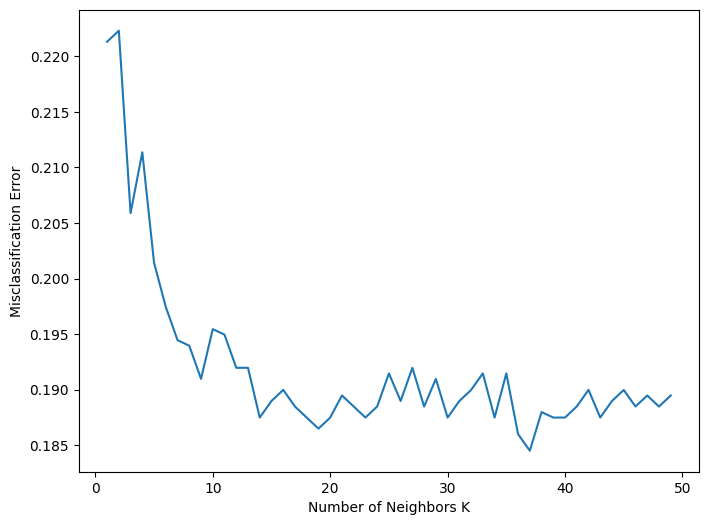

In [ ]:
# changing to misclassification error
MSE = [1 - x for x in cv_scores]


# plot misclassification error vs k
plt.figure(figsize=(8, 6))
plt.plot(k_neighbors, MSE)
plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()

---

**Discussion Question:** Based on this graph, which value of $K$ would you choose?

In [ ]:
#| code-fold: true
#| code-summary: "Solution"
# Based on this graph I would probably choose K=15, which allows for maximal 
# model complexity with minimal misclassification.

---